In [1]:
from functools import partial

import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sklearn.linear_model, sklearn.calibration

import loader
from models import DummyEstimator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.5  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

max_workers = 32

data_dir = "data/compas"

In [2]:
## Load ProPublica COMPAS dataset
dataset_name = "COMPAS"

(inputs_df, labels, label_names, groups,
 group_names) = loader.load_compas(data_dir)
inputs_u_df = loader.load_compas(data_dir, remove_sensitive_attr=True)[0]
      
display(loader.dataset_stats(labels, label_names, groups, group_names))

n_classes = len(label_names)
n_groups = len(group_names)

inputs = np.array(inputs_df.values, dtype=np.float32)
inputs_u = np.array(inputs_u_df.values, dtype=np.float32)

Group,African-American,Caucasian
Target,,
No,1402,1229
Yes,1773,874


In [3]:
## Split data into (test + post-processing) and pre-training sets

(inputs_, inputs_pretrain, inputs_u_, inputs_u_pretrain, labels_,
 labels_pretrain, groups_,
 groups_pretrain) = sklearn.model_selection.train_test_split(
     inputs,
     inputs_u,
     labels,
     groups,
     test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
     random_state=seed_pretrain,
 )

# Encode the joint (A, Y) labels by flattening
labels_ay_pretrain = groups_pretrain * n_classes + labels_pretrain

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
inputs_pretrain = scaler.fit_transform(inputs_pretrain)
inputs_ = scaler.transform(inputs_)

scaler = sklearn.preprocessing.StandardScaler()
inputs_u_pretrain = scaler.fit_transform(inputs_u_pretrain)
inputs_u_ = scaler.transform(inputs_u_)

n_samples = len(inputs)
n_test = int(n_samples * split_ratio_test)

In [4]:
# Calibrator definition

calibrator_ay_factory = partial(sklearn.calibration.CalibratedClassifierCV,
                             estimator=DummyEstimator(n_classes * n_groups),
                             cv='prefit',
                             method='sigmoid')

## Logistic regression

In [5]:
model_name = 'log. reg.'

# Train attribute aware p(Y | X, A) predictor
predictor_y = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute blind p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print('Binned ECE of attribute aware predictor:',
      utils.calibration_error(predictor_y.predict_proba(inputs_), labels_))
print(
    'Binned ECE of attribute blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_))

Binned ECE of attribute aware predictor: 0.1647822771967753
Binned ECE of attribute blind predictor: 0.3253485209535967


In [6]:
# Precompute P(A, Y | X, A) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'p_ay_x': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'p_ay_x': probas_ay_u_}

  0%|                                                    | 0/75 [00:00<?, ?it/s]

 43%|██████████████████▎                        | 32/75 [00:00<00:00, 50.32it/s]

 85%|████████████████████████████████████▋      | 64/75 [00:03<00:00, 16.75it/s]

100%|███████████████████████████████████████████| 75/75 [00:03<00:00, 21.80it/s]

  0%|                                                    | 0/75 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 75/75 [00:00<00:00, 7524.76it/s]

  0%|                                                    | 0/75 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 75/75 [00:00<00:00, 4294.92it/s]

  0%|                                                    | 0/75 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 75/75 [00:00<00:00, 5441.40it/s]

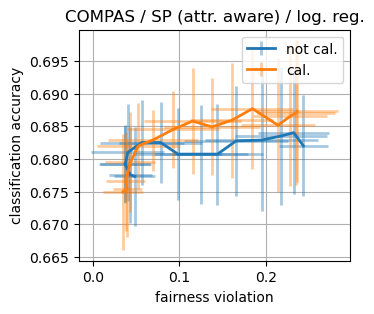

Results for attribute aware (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.681996  0.007719  0.243296  0.028292
0.240  0.684018  0.009427  0.232082  0.040717
0.220  0.683512  0.010542  0.217679  0.053186
0.200  0.682881  0.010841  0.194874  0.064948
0.180  0.682754  0.008397  0.165456  0.060369
0.160  0.680733  0.007719  0.143957  0.052160
0.140  0.680733  0.007588  0.125169  0.054170
0.120  0.680733  0.007043  0.098253  0.050534
0.100  0.682502  0.006247  0.078299  0.048257
0.080  0.682502  0.006544  0.056251  0.048536
0.060  0.680985  0.007407  0.040181  0.041927
0.040  0.679217  0.006033  0.037413  0.030154
0.020  0.679217  0.005882  0.036892  0.028909
0.010  0.677574  0.007321  0.043249  0.025177
0.001  0.677322  0.007559  0.048114  0.023344

Results for attribute aware (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.687303  0.010841  0.236065  0.047320
0.240  0.687050  0.011110  0.234892  0.045397
0.220  0.686545  0.010706  0.228225  0.042847
0.200  0.685155  0.010231  0.213951  0.042645
0.180  0.687682  0.009204  0.184343  0.047365
0.160  0.685913  0.008803  0.160477  0.048209
0.140  0.684902  0.007426  0.137629  0.055152
0.120  0.685786  0.008097  0.115131  0.055614
0.100  0.684523  0.005868  0.093008  0.053193
0.080  0.682881  0.004664  0.069083  0.051828
0.060  0.681996  0.006544  0.052432  0.048146
0.040  0.679469  0.007667  0.043182  0.028839
0.020  0.676563  0.007594  0.037879  0.022429
0.010  0.675426  0.007304  0.039507  0.016597
0.001  0.674921  0.008896  0.034657  0.023191

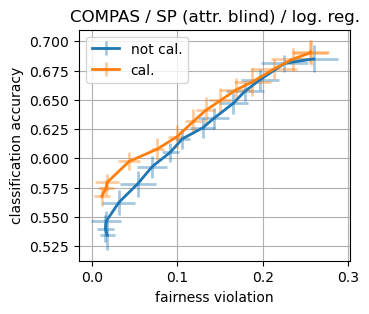

Results for attribute blind (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.684902  0.011574  0.259447  0.028586
0.240  0.681112  0.007546  0.225319  0.027485
0.220  0.667088  0.009023  0.196656  0.022283
0.200  0.657107  0.008373  0.178759  0.022066
0.180  0.646873  0.009012  0.165260  0.017013
0.160  0.634112  0.008655  0.142588  0.018093
0.140  0.626027  0.008708  0.129718  0.014411
0.120  0.616677  0.008769  0.105934  0.008811
0.100  0.605054  0.008409  0.091597  0.009842
0.080  0.592925  0.009440  0.070624  0.017441
0.060  0.578395  0.011146  0.053831  0.021320
0.040  0.562224  0.010841  0.031495  0.019511
0.020  0.546304  0.008620  0.016866  0.017309
0.010  0.539987  0.011703  0.015735  0.009781
0.001  0.534302  0.012849  0.017971  0.008727

Results for attribute blind (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.690967  0.009729  0.255403  0.021525
0.240  0.690208  0.010679  0.255985  0.020627
0.220  0.684649  0.009851  0.234786  0.025386
0.200  0.676311  0.008388  0.212884  0.027001
0.180  0.665193  0.012044  0.187530  0.021793
0.160  0.658497  0.010538  0.168690  0.018584
0.140  0.649400  0.010832  0.150295  0.013009
0.120  0.640935  0.011498  0.133154  0.010762
0.100  0.631459  0.010367  0.118701  0.009611
0.080  0.618572  0.009729  0.099790  0.011029
0.060  0.607960  0.009680  0.076718  0.008110
0.040  0.597347  0.007732  0.043609  0.013194
0.020  0.579533  0.007085  0.018076  0.013844
0.010  0.574858  0.006565  0.016562  0.009227
0.001  0.567404  0.008314  0.011592  0.009428

In [7]:
## Post-processing for statistical parity
criterion = 'sp'
criterion_name = 'SP'
alphas_aware = [np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08,
                0.06, 0.04, 0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08,
                0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/70 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 3913.17it/s]

  0%|                                                    | 0/70 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 4671.76it/s]

  0%|                                                    | 0/75 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 75/75 [00:00<00:00, 3934.67it/s]

  0%|                                                    | 0/75 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 75/75 [00:00<00:00, 6308.36it/s]

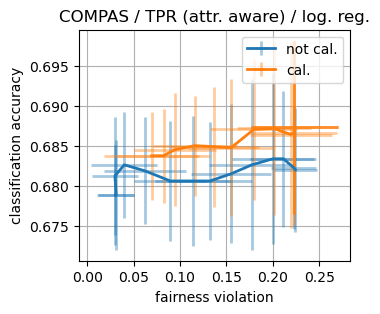

Results for attribute aware (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.681996  0.007719   0.224155  0.023046
0.220  0.682249  0.007698   0.222622  0.024250
0.200  0.683386  0.008492   0.211338  0.035527
0.180  0.683386  0.010696   0.200155  0.044023
0.160  0.682628  0.010689   0.177335  0.045809
0.140  0.681491  0.008701   0.154631  0.043338
0.120  0.680606  0.007416   0.132201  0.045098
0.100  0.680606  0.008110   0.114418  0.041740
0.080  0.680606  0.007496   0.089466  0.038665
0.060  0.681870  0.006709   0.062091  0.043829
0.040  0.682628  0.006649   0.039885  0.035390
0.020  0.681238  0.007429   0.029788  0.024712
0.010  0.678838  0.006900   0.031116  0.019329
0.001  0.678838  0.006263   0.030246  0.019856

Results for attribute aware (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.687303  0.010841   0.223083  0.047157
0.220  0.687303  0.010841   0.223083  0.047157
0.200  0.687303  0.010841   0.223083  0.047157
0.180  0.687303  0.010841   0.223083  0.047157
0.160  0.686671  0.011554   0.222714  0.046629
0.140  0.686418  0.011636   0.219294  0.044448
0.120  0.687176  0.010844   0.201121  0.040339
0.100  0.687050  0.008862   0.179326  0.046711
0.080  0.684776  0.008534   0.155022  0.046023
0.060  0.684902  0.007520   0.136975  0.048144
0.040  0.685028  0.006263   0.115896  0.045032
0.020  0.684523  0.007043   0.094422  0.044085
0.010  0.683765  0.005902   0.082126  0.049787
0.001  0.683765  0.005518   0.069473  0.051357

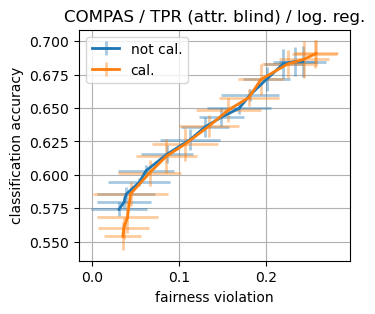

Results for attribute blind (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.684902  0.011574   0.242624  0.027334
0.240  0.684902  0.010927   0.233772  0.025045
0.220  0.683260  0.010983   0.220491  0.022160
0.200  0.671762  0.009150   0.201237  0.026879
0.180  0.659760  0.004612   0.181849  0.033658
0.160  0.649779  0.004502   0.169278  0.037312
0.140  0.643209  0.006525   0.148905  0.026342
0.120  0.636008  0.007440   0.130243  0.027752
0.100  0.626279  0.007860   0.112581  0.034914
0.080  0.615414  0.006766   0.086023  0.029941
0.060  0.603159  0.004542   0.061966  0.032337
0.040  0.594441  0.002860   0.054094  0.035865
0.020  0.585471  0.005745   0.038916  0.033795
0.010  0.579659  0.004823   0.036463  0.030827
0.001  0.574226  0.005323   0.030805  0.031952

Results for attribute blind (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.690967  0.009729   0.258208  0.025372
0.240  0.690335  0.010508   0.256393  0.026426
0.220  0.686545  0.013821   0.244065  0.029221
0.200  0.683007  0.010441   0.225363  0.030101
0.180  0.671510  0.011380   0.194575  0.026008
0.160  0.657865  0.006069   0.180599  0.034892
0.140  0.648642  0.008882   0.156995  0.037692
0.120  0.636387  0.008400   0.134364  0.034766
0.100  0.622994  0.012358   0.106845  0.038099
0.080  0.614024  0.012815   0.085410  0.035626
0.060  0.601642  0.009721   0.066147  0.036211
0.040  0.585723  0.008815   0.043974  0.043092
0.020  0.568162  0.011857   0.040431  0.034703
0.010  0.560202  0.008278   0.036247  0.029364
0.001  0.554011  0.010495   0.035098  0.021396

In [8]:
## Post-processing for equal opportunity
criterion = 'eopp'
criterion_name = 'TPR'
alphas_aware = [np.inf, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
                0.04, 0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08,
                0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/70 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 3592.68it/s]

  0%|                                                    | 0/70 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 5596.99it/s]

  0%|                                                    | 0/75 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 75/75 [00:00<00:00, 4825.40it/s]

  0%|                                                    | 0/75 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 75/75 [00:00<00:00, 4279.15it/s]

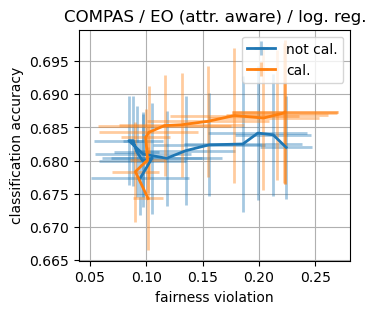

Results for attribute aware (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.681996  0.007719  0.224155  0.023046
0.220  0.683891  0.009204  0.212555  0.033486
0.200  0.684144  0.010157  0.199035  0.043838
0.180  0.682502  0.010270  0.185741  0.052280
0.160  0.682375  0.007755  0.155684  0.049797
0.140  0.681491  0.008205  0.135025  0.044034
0.120  0.680354  0.007147  0.118171  0.049355
0.100  0.680985  0.006396  0.097155  0.042821
0.080  0.683007  0.006736  0.084617  0.030625
0.060  0.683007  0.006766  0.088506  0.008740
0.040  0.681364  0.006813  0.091485  0.019952
0.020  0.679975  0.007015  0.096856  0.038409
0.010  0.680354  0.008357  0.105115  0.044703
0.001  0.677322  0.005532  0.094583  0.043154

Results for attribute aware (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.687303  0.010841  0.223083  0.047157
0.220  0.687303  0.010841  0.223083  0.047157
0.200  0.687176  0.010603  0.222327  0.046631
0.180  0.686924  0.009772  0.215954  0.045044
0.160  0.686418  0.010782  0.204066  0.049494
0.140  0.686797  0.010200  0.178227  0.057382
0.120  0.685913  0.008338  0.154568  0.054036
0.100  0.685407  0.007827  0.131373  0.055544
0.080  0.685281  0.007559  0.116282  0.058859
0.060  0.684270  0.006983  0.102382  0.043906
0.040  0.683512  0.004190  0.099511  0.021570
0.020  0.680101  0.005026  0.101215  0.015250
0.010  0.678332  0.007559  0.090401  0.020553
0.001  0.674289  0.007796  0.101668  0.013178

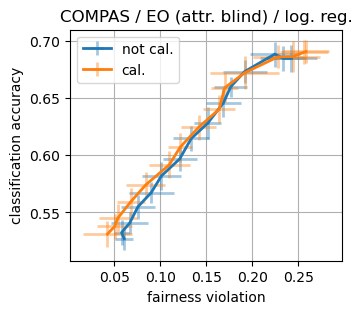

Results for attribute blind (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.684902  0.011574  0.242624  0.027334
0.240  0.684902  0.010927  0.233772  0.025045
0.220  0.688692  0.010881  0.224541  0.026927
0.200  0.673405  0.010245  0.191734  0.023871
0.180  0.660139  0.008799  0.176674  0.017914
0.160  0.645989  0.012181  0.168662  0.018953
0.140  0.628174  0.013816  0.151621  0.014344
0.120  0.614782  0.010584  0.133753  0.019448
0.100  0.596968  0.010711  0.121250  0.018205
0.080  0.582059  0.012107  0.101419  0.021629
0.060  0.567404  0.008983  0.090285  0.024687
0.040  0.554896  0.010250  0.075765  0.018609
0.020  0.540872  0.009801  0.066973  0.019854
0.010  0.532407  0.011189  0.058082  0.008196
0.001  0.527100  0.010182  0.060884  0.009556

Results for attribute blind (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.690967  0.009729  0.258208  0.025372
0.240  0.690335  0.010508  0.256393  0.026426
0.220  0.686545  0.013821  0.244065  0.029221
0.200  0.686292  0.010123  0.227986  0.027283
0.180  0.672394  0.014340  0.191899  0.037477
0.160  0.659128  0.012678  0.169999  0.014414
0.140  0.640430  0.012406  0.164113  0.017527
0.120  0.624510  0.011217  0.141675  0.019324
0.100  0.607075  0.012721  0.121629  0.012984
0.080  0.591788  0.011998  0.109917  0.022043
0.060  0.574226  0.011149  0.084410  0.021296
0.040  0.559570  0.012269  0.068262  0.014833
0.020  0.545167  0.011986  0.054069  0.020837
0.010  0.537713  0.011215  0.050465  0.019011
0.001  0.531143  0.011720  0.042744  0.026997

In [9]:
## Post-processing for equalized odds
criterion = 'eo'
criterion_name = 'EO'
alphas_aware = [np.inf, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
                0.04, 0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08,
                0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

## Gradient boosting decision tree

In [10]:
model_name = 'GBDT'

# Train attribute aware p(Y | X, A) predictor
predictor_y = lightgbm.LGBMClassifier(random_state=seed_pretrain, verbosity=0)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute blind p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain,
                                         verbosity=0)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print('Binned ECE of attribute aware predictor:',
      utils.calibration_error(predictor_y.predict_proba(inputs_), labels_))
print(
    'Binned ECE of attribute blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_))

Binned ECE of attribute aware predictor: 0.17960510853434203
Binned ECE of attribute blind predictor: 0.6396352784473274


In [11]:
# Precompute P(A, Y | X, A) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'p_ay_x': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'p_ay_x': probas_ay_u_}

  0%|                                                    | 0/60 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 60/60 [00:00<00:00, 11538.13it/s]

  0%|                                                    | 0/60 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 60/60 [00:00<00:00, 14358.32it/s]

  0%|                                                    | 0/60 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 60/60 [00:00<00:00, 11190.78it/s]

  0%|                                                    | 0/60 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 8751.50it/s]

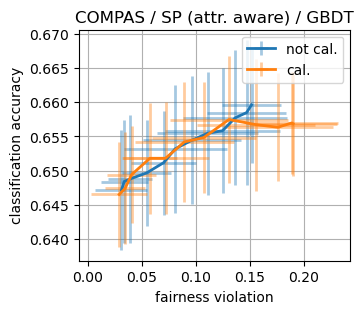

Results for attribute aware (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.659634  0.008468  0.151550  0.027754
0.180  0.658497  0.010614  0.146973  0.036791
0.160  0.657738  0.009882  0.136442  0.048312
0.140  0.655843  0.009191  0.124692  0.053437
0.120  0.655464  0.009029  0.110850  0.046841
0.100  0.654454  0.009370  0.096418  0.045358
0.080  0.653190  0.009423  0.080770  0.047636
0.060  0.651169  0.007612  0.070200  0.030154
0.040  0.649653  0.007770  0.054357  0.022535
0.020  0.648768  0.009359  0.038892  0.020830
0.010  0.648389  0.009051  0.033509  0.021630
0.001  0.647126  0.008806  0.030998  0.024130

Results for attribute aware (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.656854  0.007651  0.190072  0.040707
0.180  0.656980  0.007448  0.188917  0.042849
0.160  0.656349  0.007903  0.175893  0.050767
0.140  0.656728  0.009690  0.155816  0.055001
0.120  0.657486  0.009342  0.130659  0.054758
0.100  0.654833  0.008110  0.107217  0.048336
0.080  0.654201  0.008817  0.089303  0.045652
0.060  0.651800  0.008229  0.071836  0.039906
0.040  0.651800  0.008119  0.057364  0.025026
0.020  0.649400  0.007105  0.040354  0.023105
0.010  0.647378  0.008217  0.034368  0.018499
0.001  0.646494  0.007706  0.028860  0.025651

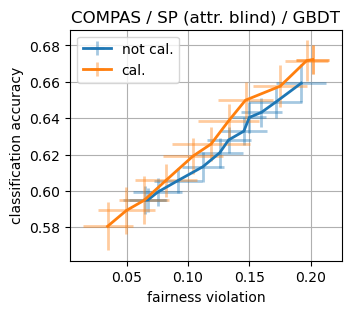

Results for attribute blind (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.659255  0.010500  0.192264  0.020597
0.180  0.648895  0.009049  0.171581  0.021612
0.160  0.643209  0.008058  0.159820  0.016678
0.140  0.640430  0.008655  0.149967  0.013860
0.120  0.632849  0.007703  0.145472  0.018834
0.100  0.628048  0.007040  0.133090  0.017865
0.080  0.620973  0.008273  0.125806  0.019348
0.060  0.613266  0.008326  0.111990  0.017179
0.040  0.605685  0.006969  0.091750  0.019856
0.020  0.599368  0.007651  0.075355  0.019923
0.010  0.595073  0.006580  0.067293  0.015594
0.001  0.594946  0.007703  0.064565  0.017778

Results for attribute blind (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.672268  0.008193  0.201660  0.013421
0.180  0.672268  0.008193  0.201660  0.013421
0.160  0.671636  0.011242  0.196682  0.017806
0.140  0.657612  0.011493  0.175162  0.022176
0.120  0.649905  0.010268  0.146851  0.022035
0.100  0.638534  0.009532  0.133086  0.024832
0.080  0.625774  0.009440  0.118741  0.031537
0.060  0.619204  0.010072  0.104126  0.024497
0.040  0.605812  0.009143  0.082015  0.025532
0.020  0.594820  0.013188  0.064181  0.020371
0.010  0.589261  0.012787  0.049767  0.023081
0.001  0.580543  0.013160  0.034404  0.020365

In [12]:
## Post-processing for statistical parity
criterion = 'sp'
criterion_name = 'SP'
alphas_aware = [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
                0.01, 0.001]
alphas_blind = [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
                0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/55 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 55/55 [00:00<00:00, 10762.65it/s]

  0%|                                                    | 0/55 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 7718.11it/s]

  0%|                                                    | 0/60 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 8746.03it/s]

  0%|                                                    | 0/60 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 60/60 [00:00<00:00, 10534.92it/s]

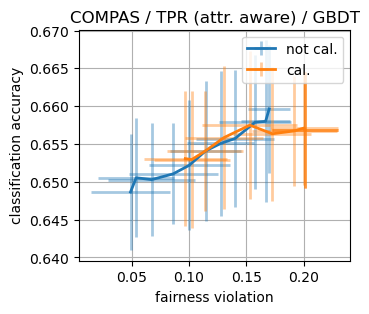

Results for attribute aware (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.659634  0.008468   0.169876  0.018247
0.160  0.657991  0.010726   0.166756  0.021288
0.140  0.657865  0.008873   0.157582  0.031057
0.120  0.655717  0.009045   0.140090  0.033921
0.100  0.655085  0.009570   0.127853  0.029208
0.080  0.654075  0.009312   0.114423  0.030857
0.060  0.652179  0.008576   0.100229  0.035177
0.040  0.651042  0.006664   0.086149  0.038720
0.020  0.650284  0.007483   0.067479  0.037850
0.010  0.650537  0.007895   0.054008  0.033053
0.001  0.648642  0.007690   0.049092  0.034003

Results for attribute aware (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.656854  0.007651   0.200954  0.028725
0.160  0.656854  0.007651   0.200954  0.028725
0.140  0.656854  0.007651   0.200954  0.028725
0.120  0.657107  0.007546   0.200121  0.029773
0.100  0.656728  0.007239   0.191800  0.037246
0.080  0.656349  0.008878   0.172592  0.033820
0.060  0.657486  0.009791   0.153040  0.041448
0.040  0.655843  0.009490   0.130513  0.034332
0.020  0.654075  0.007935   0.114255  0.032959
0.010  0.652937  0.009095   0.102412  0.033263
0.001  0.653064  0.008938   0.096794  0.036269

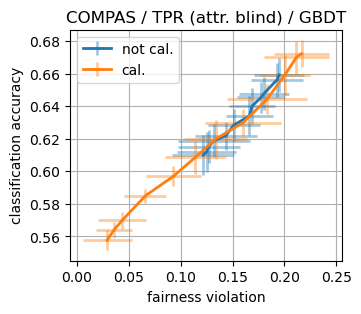

Results for attribute blind (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.659255  0.010500   0.194866  0.024466
0.180  0.656222  0.010432   0.192946  0.024923
0.160  0.647631  0.010180   0.180127  0.024137
0.140  0.645357  0.009408   0.177559  0.022973
0.120  0.640051  0.010918   0.168827  0.022522
0.100  0.633986  0.011991   0.166316  0.022367
0.080  0.628301  0.010014   0.151042  0.025011
0.060  0.621731  0.008758   0.143429  0.029860
0.040  0.618825  0.010103   0.132175  0.034558
0.020  0.615161  0.010200   0.127061  0.029653
0.010  0.611876  0.012416   0.124920  0.028206
0.001  0.609981  0.012432   0.121799  0.029827

Results for attribute blind (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.672268  0.008193   0.216463  0.026100
0.180  0.669994  0.010123   0.211569  0.031565
0.160  0.659255  0.012238   0.200522  0.023874
0.140  0.644220  0.009180   0.183201  0.038425
0.120  0.629943  0.008338   0.160275  0.036586
0.100  0.619709  0.011877   0.133592  0.030625
0.080  0.608465  0.009982   0.114011  0.029486
0.060  0.596968  0.006222   0.093041  0.026821
0.040  0.584965  0.004261   0.066069  0.020307
0.020  0.569804  0.005434   0.043570  0.022841
0.010  0.563992  0.005002   0.035759  0.017172
0.001  0.557675  0.006147   0.029160  0.023612

In [13]:
## Post-processing for equal opportunity
criterion = 'eopp'
criterion_name = 'TPR'
alphas_aware = [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
                0.001]
alphas_blind = [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
                0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/55 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 55/55 [00:00<00:00, 12353.36it/s]

  0%|                                                    | 0/55 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 55/55 [00:00<00:00, 12379.88it/s]

  0%|                                                    | 0/60 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 60/60 [00:00<00:00, 12107.10it/s]

  0%|                                                    | 0/60 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 60/60 [00:00<00:00, 32832.13it/s]

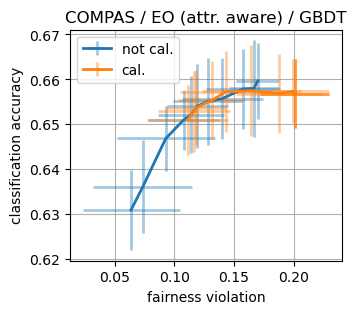

Results for attribute aware (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.659634  0.008468  0.169876  0.018247
0.160  0.657991  0.010726  0.166756  0.021288
0.140  0.657865  0.008873  0.157582  0.031057
0.120  0.655717  0.009045  0.140090  0.033921
0.100  0.655085  0.009570  0.128031  0.028893
0.080  0.654075  0.009312  0.119348  0.025626
0.060  0.652179  0.008576  0.114204  0.027740
0.040  0.651042  0.006664  0.108026  0.030193
0.020  0.646873  0.007189  0.092804  0.041077
0.010  0.636134  0.010274  0.073541  0.041613
0.001  0.630954  0.008961  0.063651  0.040662

Results for attribute aware (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.656854  0.007651  0.200954  0.028725
0.160  0.656854  0.007651  0.200954  0.028725
0.140  0.656854  0.007651  0.200954  0.028725
0.120  0.657359  0.007127  0.199751  0.030180
0.100  0.656854  0.008712  0.187510  0.035413
0.080  0.657486  0.010111  0.164478  0.041380
0.060  0.657233  0.009018  0.143194  0.038757
0.040  0.655338  0.008691  0.131386  0.028197
0.020  0.653696  0.008397  0.118388  0.025085
0.010  0.652937  0.009007  0.116499  0.030087
0.001  0.651042  0.007770  0.111155  0.033860

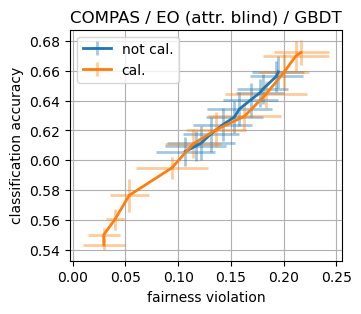

Results for attribute blind (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.659255  0.010500  0.194866  0.024466
0.180  0.656222  0.010432  0.192946  0.024923
0.160  0.647631  0.010180  0.180127  0.024137
0.140  0.645357  0.009408  0.177559  0.022973
0.120  0.640303  0.011472  0.168534  0.025897
0.100  0.634365  0.011189  0.158028  0.030629
0.080  0.628932  0.010623  0.153209  0.027323
0.060  0.623752  0.011047  0.142106  0.027633
0.040  0.617435  0.011619  0.130721  0.026573
0.020  0.611497  0.011380  0.121685  0.032205
0.010  0.609476  0.010316  0.116456  0.028739
0.001  0.605812  0.009958  0.106648  0.027825

Results for attribute blind (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.672268  0.008193  0.216463  0.026100
0.180  0.669994  0.010123  0.211569  0.031565
0.160  0.659255  0.012238  0.200522  0.023874
0.140  0.644220  0.009180  0.183201  0.038425
0.120  0.629438  0.009106  0.162714  0.034640
0.100  0.620467  0.011557  0.136018  0.028309
0.080  0.610992  0.009739  0.114267  0.026747
0.060  0.594820  0.007615  0.093882  0.033963
0.040  0.576500  0.011244  0.053587  0.018687
0.020  0.560455  0.007054  0.040105  0.008325
0.010  0.549968  0.004926  0.029382  0.015061
0.001  0.543272  0.003601  0.029487  0.020114

In [14]:
## Post-processing for equalized odds
criterion = 'eo'
criterion_name = 'EO'
alphas_aware = [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
                0.001]
alphas_blind = [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
                0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)